## Imports

In [1]:
from pyofss import *
import numpy as np
import matplotlib as mpl
import matplotlib
import pylab as plt
plt.switch_backend('agg')

import os.path
import pyopencl as cl
from pynvml import *

import time
%matplotlib inline


In [2]:
mpl.rcParams['agg.path.chunksize'] = 10000
font = {'family' : 'DejaVu Sans',
        'size'   : 16}

matplotlib.rc('font', **font)

## Check devices availible

In [3]:
platforms = cl.get_platforms() 
devices = [] 
for platform in platforms: 
    devices.extend(platform.get_devices()) 
device_count = len(devices) 
print(devices[0].name)
print(devices[1].name)
print(device_count) 

NVIDIA GeForce RTX 4090
NVIDIA GeForce RTX 4090
2


# Choose platform

In [5]:
platform = cl.get_platforms()[0] # get the first platform

## Define amplifier parameters

In [6]:
Pp_0 = 10               # W
N = 4.8
Rr = 80*1e-6            # THz
Tr = 1/Rr 
lamb0 = 1028
length = 8*1e-3
gamma = 5.1
betta_arr = np.array([0, 0, 20])

# Define process parameters

In [7]:
total_steps = 30000
traces = 500
method="rk4ip" # no raman realisation in cl_ss_symmetric for opencl!
method_ocl = "cl_rk4ip"
downsampling = 4000

## Define pulse and domain

In [8]:
domain = Domain(samples_per_bit=2**14, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(lamb0))
gaussian = Gaussian(peak_power=600, width=2, C=0, using_fwhm=True)

interpolated_t = get_downsampled(domain.t, downsampling)
interpolated_nu = get_downsampled(domain.nu, downsampling)
interpolated_lambda = get_downsampled(domain.Lambda, downsampling)

# Helper functions

In [9]:
def check_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Directory: ", dir, " is created!")
        
def get_device_memory_info():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"device name {nvmlDeviceGetName(handle)}")
    print("Total memory: {} MiB".format(info.total >> 20))
    print("Free memory: {} MiB".format(info.free >> 20))
    print("Used memory: {} MiB".format(info.used >> 20))
    nvmlShutdown()

## 0. Compare Fibre and OpenclFibre modules: with raman, with Yb amplification model

In [10]:
sys0 = System(domain)
sys0.add(gaussian)
sys0.add(Fibre(length=length, method=method, total_steps=total_steps,
            beta=betta_arr, gamma=gamma , self_steepening=False, use_all='hollenbeck', cycle=f'cycle0', traces=traces, 
               Pp_0=Pp_0, N=N, Rr=1/Tr, use_Yb_model=True,  downsampling=downsampling))
start = time.time()
sys0.run()
stop = time.time()
no_cl_time = stop-start
print(f"Run time without cl is {no_cl_time} s")

platform = cl.get_platforms()[0] # get the first platform
device = platform.get_devices(device_type=cl.device_type.GPU)[0] # get the first GPU device
cl_program = OpenclProgramm(fast_math=True, use_all='hollenbeck', dorf='double', ctx=cl.Context([device]), downsampling=downsampling)
cl_program.set_domain(domain)
sys1 = System(domain)
sys1.add(gaussian)
amplifier = Amplifier2LevelModel(Pp=Pp_0, N=N, Rr=1/Tr, prg=cl_program.prg, queue=cl_program.queue, ctx=cl_program.ctx)
sys1.add(OpenclFibre(cl_programm=cl_program, length=length, total_steps=total_steps,
            beta=betta_arr, gamma=gamma, self_steepening=False, method=method_ocl, 
                     cycle=f'cycle0',traces=traces, amplifier=amplifier))
start = time.time()
sys1.run()
stop = time.time()
cl_time = stop-start

print(f"Run time with cl is {cl_time} s")
print(f"cl is faster in {no_cl_time/cl_time} times")

Using general expression for nonlinearity
gaussian
fibre


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:351: RuntimeWarning: invalid value encountered in divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:285: RuntimeWarning: divide by zero encountered in divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (self.T * (self.sigma12_s + self.sigma21_s) * self.rho_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:241: SavingWarning: Nothing will be saved - the base fibre directory is not stated!
  warnings.warn("Nothing will be saved - the base fibre directory is not stated!", SavingWarning)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:285: RuntimeWarning: divide by zero encountered in divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (self.T * (self.sigma12_s + self.sigma21_s) * self.rho_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:351: RuntimeWarning: invalid value encounter

Run time without cl is 143.2171881198883 s
Using compiler optimisations suitable for Nvidia GPUs
Using general expression for nonlinearity
gaussian
cl_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 4191 MiB
Run time with cl is 120.28805088996887 s
cl is faster in 1.1906185781569727 times


### Visualise results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Generating multi_plot...


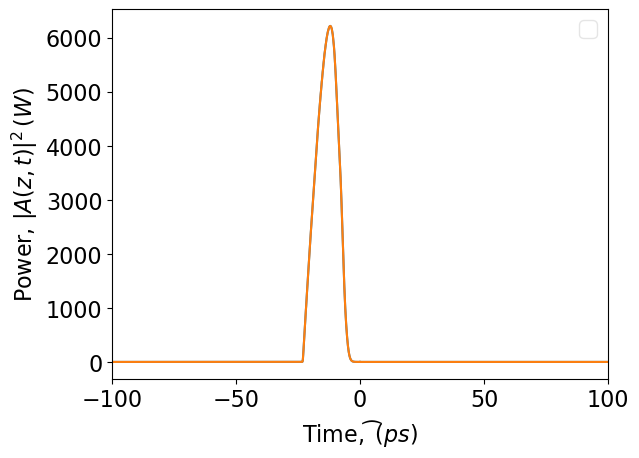

In [15]:
multi_plot(sys1.domain.t, [temporal_power(sys0.field), temporal_power(sys1.field)], ["cpu", "gpu"], labels["t"], labels["P_t"],
            x_range=(-100.0, 100.0), use_fill=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Generating multi_plot...


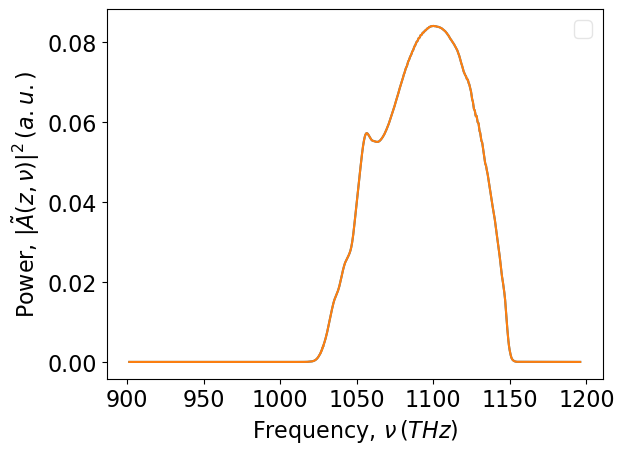

In [16]:
multi_plot(sys1.domain.Lambda, [spectral_power(sys0.field), spectral_power(sys1.field)], ["cpu", "gpu"], labels["nu"], labels["P_nu"], use_fill=False)

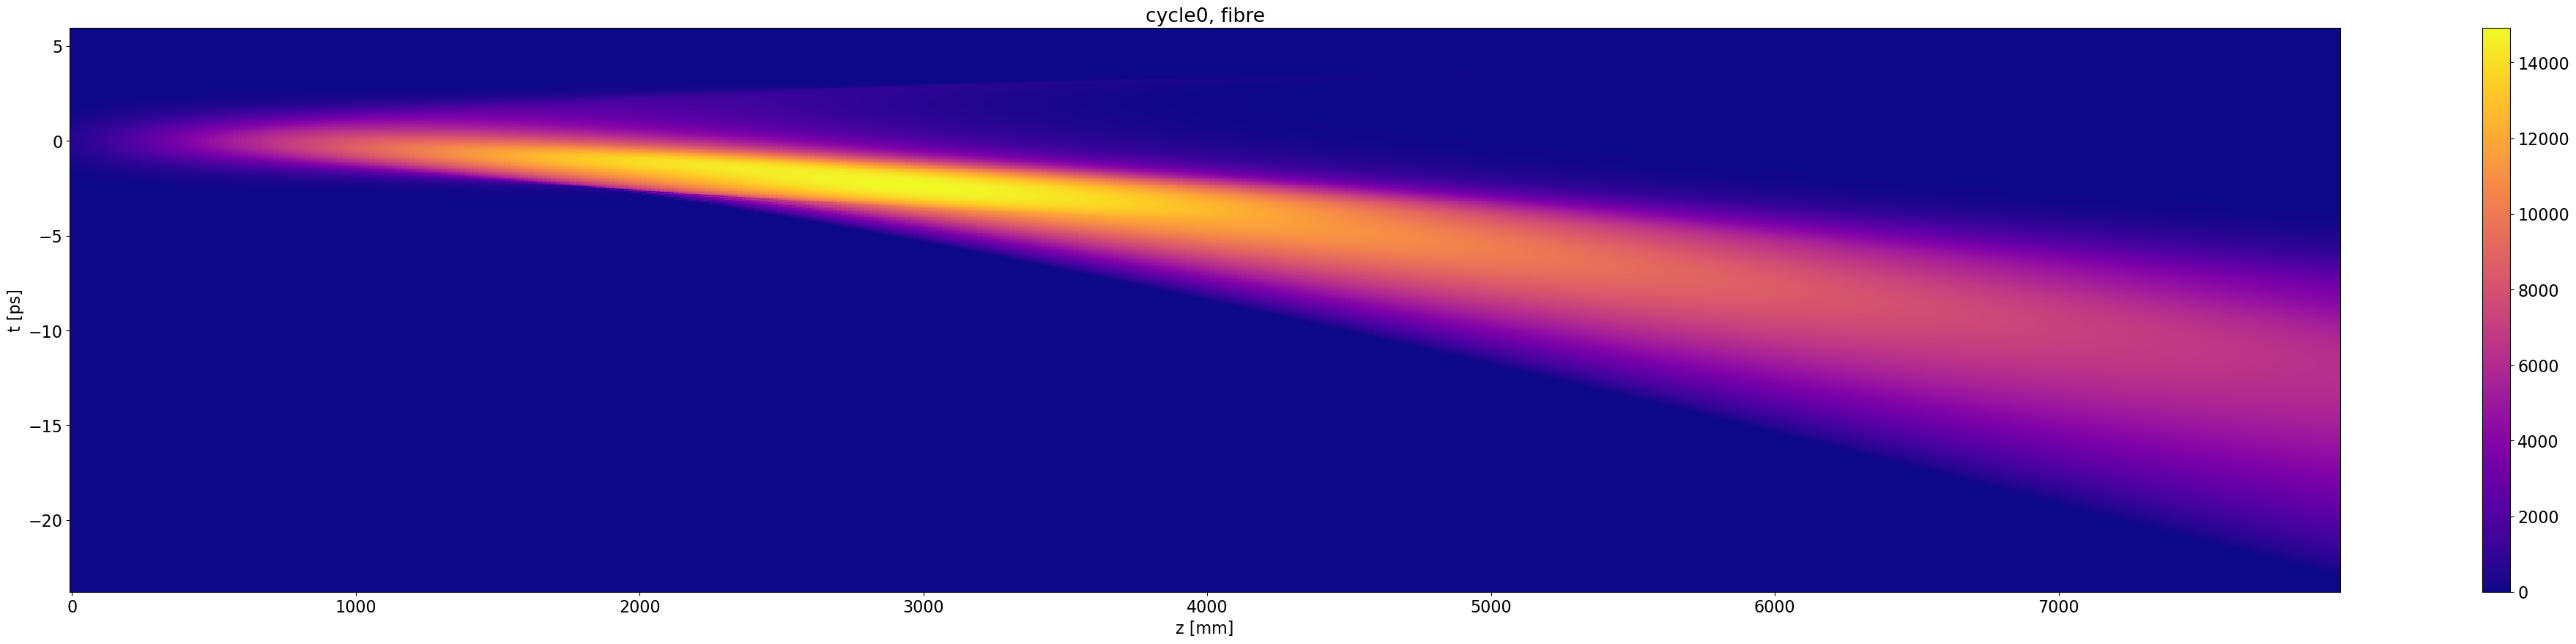

In [18]:
visualise_fields_df(sys0.df_temp, get_downsampled(domain.t, downsampling=downsampling), "t [ps]", (-50, 50), auto_lims=True)

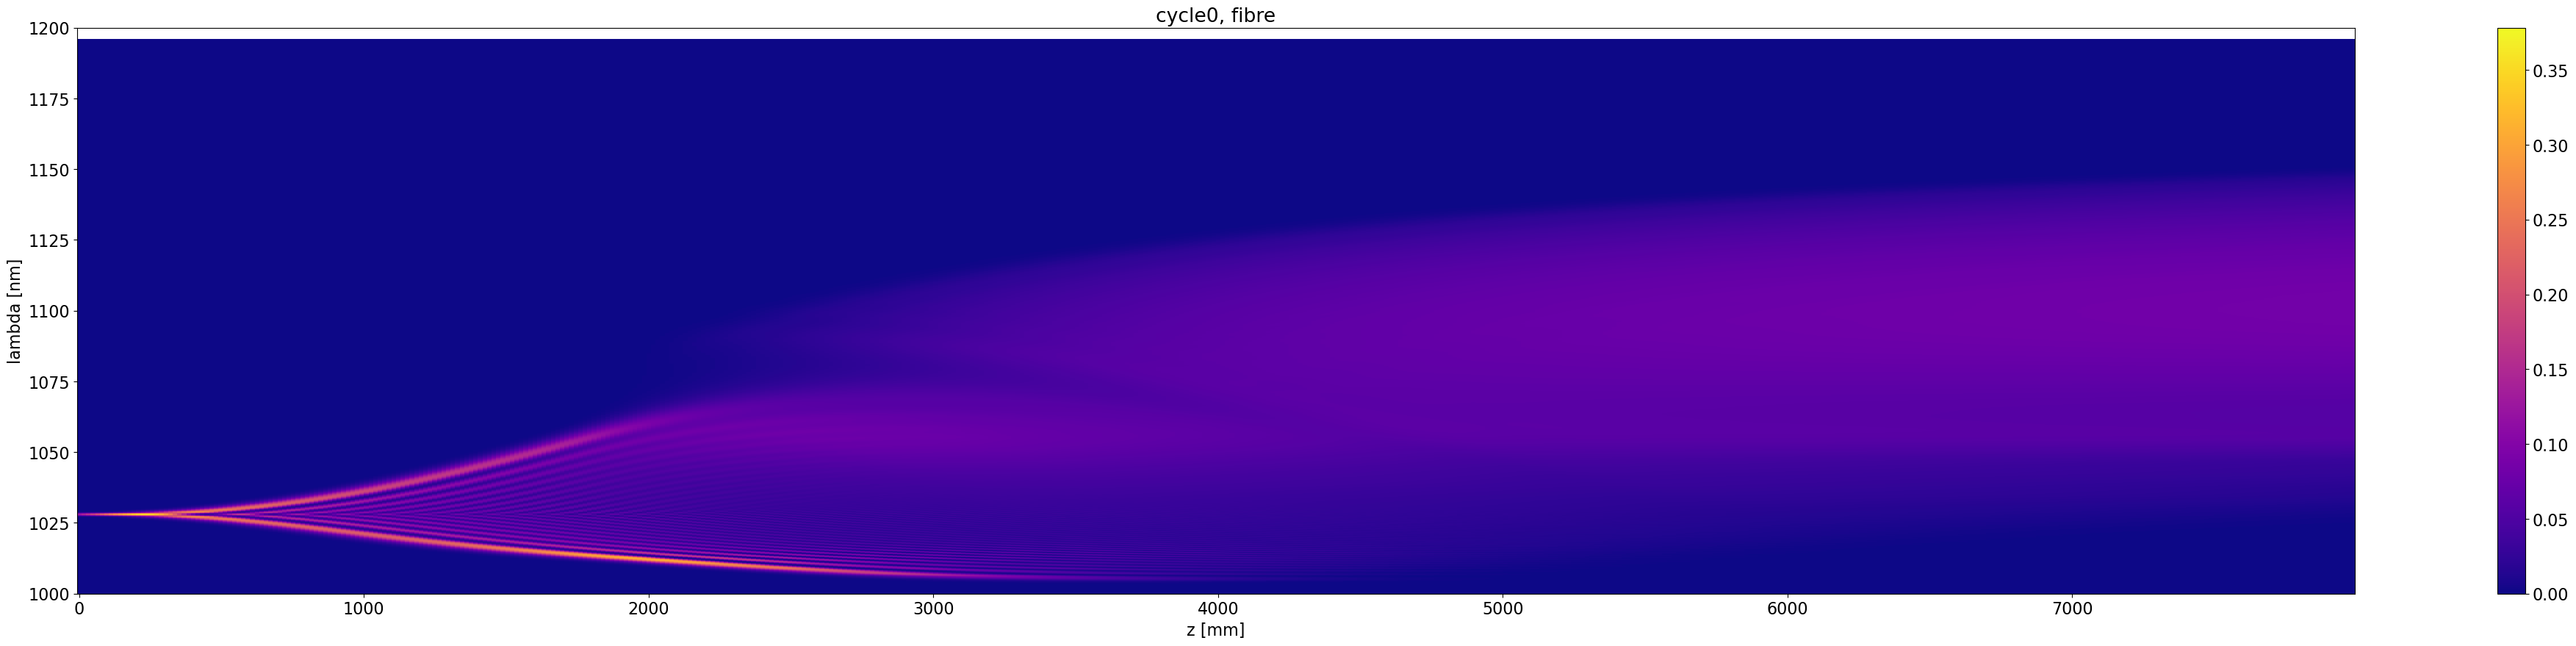

In [19]:
visualise_fields_df(sys0.df_spec, get_downsampled(domain.Lambda, downsampling=downsampling), "lambda [nm]", (1000, 1200), auto_lims=False)

In [26]:
visualise_fields_df(sys1.df_temp, get_downsampled(domain.t, downsampling=downsampling), "t [ps]", (-1, 1))
visualise_fields_df(sys1.df_spec, get_downsampled(domain.Lambda, downsampling=downsampling), "lambda [nm]", (1500, 1600))

# Check parameters calculated during propagation

## Check no opencl system

In [20]:
sys0.df_results

Peak Power [W]  Energy [nJ]  Temp width [ps]  \
cycle  fibre z [mm]                                                      
cycle0 fibre 0.266667         601.236774     1.279995         2.000007   
             16.266667        678.532671     1.444703         2.000205   
             32.266667        761.856792     1.622315         2.000465   
             48.266667        851.088443     1.812597         2.000794   
             64.266667        946.051017     2.015199         2.001200   
...                                  ...          ...              ...   
             7920.266667     6285.002164    67.427840        11.098679   
             7936.266667     6270.845134    67.442464        11.126199   
             7952.266667     6256.727038    67.456951        11.153894   
             7968.266667     6242.648567    67.471301        11.181782   
             7984.266667     6228.681636    67.485517        11.209859   

                          Spec width [THz]  Dispersion length [km]  \
cycle  fibre z [mm]                                                  
cycle0 fibre 0.266667             0.220641                0.200001   
             16.266667            0.220632                0.200041   
             32.266667            0.220683                0.200093   
             48.266667            0.220814                0.200159   
             64.266667            0.221053                0.200240   
...                                    ...                     ...   
             7920.266667         29.680000                6.159033   
             7936.266667         29.675000                6.189615   
             7952.266667         29.670000                6.220468   
             7968.266667         29.665000                6.251613   
             7984.266667         29.660000                6.283047   

                          Nonlinear length [km] Peaks [idx]  
cycle  fibre z [mm]                                          
cycle0 fibre 0.266667                  0.000326      [8192]  
             16.266667                 0.000289      [8192]  
             32.266667                 0.000257      [8192]  
             48.266667                 0.000230      [8192]  
             64.266667                 0.000207      [8192]  
...                                         ...         ...  
             7920.266667               0.000031      [7224]  
             7936.266667               0.000031      [7221]  
             7952.266667               0.000031      [7218]  
             7968.266667               0.000031      [7216]  
             7984.266667               0.000031      [7214]  

[500 rows x 7 columns]

## Check opencl system (only energy and maxvalue are calclacted using opencl)

In [21]:
sys1.df_results

Peak Power [W]         Energy [nJ]  \
cycle  fibre    z [mm]                                               
cycle0 cl_fibre 0.266667     601.2367736766179  1.2799954187492932   
                16.266667    678.5326708086575  1.4447025023057485   
                32.266667    761.8567920414721  1.6223148765745687   
                48.266667    851.0884429283365  1.8125970272808114   
                64.266667    946.0510173776896   2.015198583190597   
...                                        ...                 ...   
                7920.266667  6285.002161435167   67.42784007413192   
                7936.266667  6270.845131378815   67.44246402755448   
                7952.266667  6256.727035013434    67.4569503970595   
                7968.266667  6242.648563055674   67.47130151409496   
                7984.266667   6228.68163180182   67.48551672468625   

                            Temp width [ps] Spec width [THz]  \
cycle  fibre    z [mm]                                         
cycle0 cl_fibre 0.266667                NaN              NaN   
                16.266667               NaN              NaN   
                32.266667               NaN              NaN   
                48.266667               NaN              NaN   
                64.266667               NaN              NaN   
...                                     ...              ...   
                7920.266667             NaN              NaN   
                7936.266667             NaN              NaN   
                7952.266667             NaN              NaN   
                7968.266667             NaN              NaN   
                7984.266667             NaN              NaN   

                             Dispersion length [km]  Nonlinear length [km]  \
cycle  fibre    z [mm]                                                       
cycle0 cl_fibre 0.266667                   0.200001               0.000326   
                16.266667                  0.200041               0.000289   
                32.266667                  0.200093               0.000257   
                48.266667                  0.200159               0.000230   
                64.266667                  0.200240               0.000207   
...                                             ...                    ...   
                7920.266667                6.159033               0.000031   
                7936.266667                6.189615               0.000031   
                7952.266667                6.220468               0.000031   
                7968.266667                6.251612               0.000031   
                7984.266667                6.283047               0.000031   

                            Peaks [idx]  
cycle  fibre    z [mm]                   
cycle0 cl_fibre 0.266667            NaN  
                16.266667           NaN  
                32.266667           NaN  
                48.266667           NaN  
                64.266667           NaN  
...                                 ...  
                7920.266667         NaN  
                7936.266667         NaN  
                7952.266667         NaN  
                7968.266667         NaN  
                7984.266667         NaN  

[500 rows x 7 columns]

Text(0, 0.5, 'Ld/Lnl')

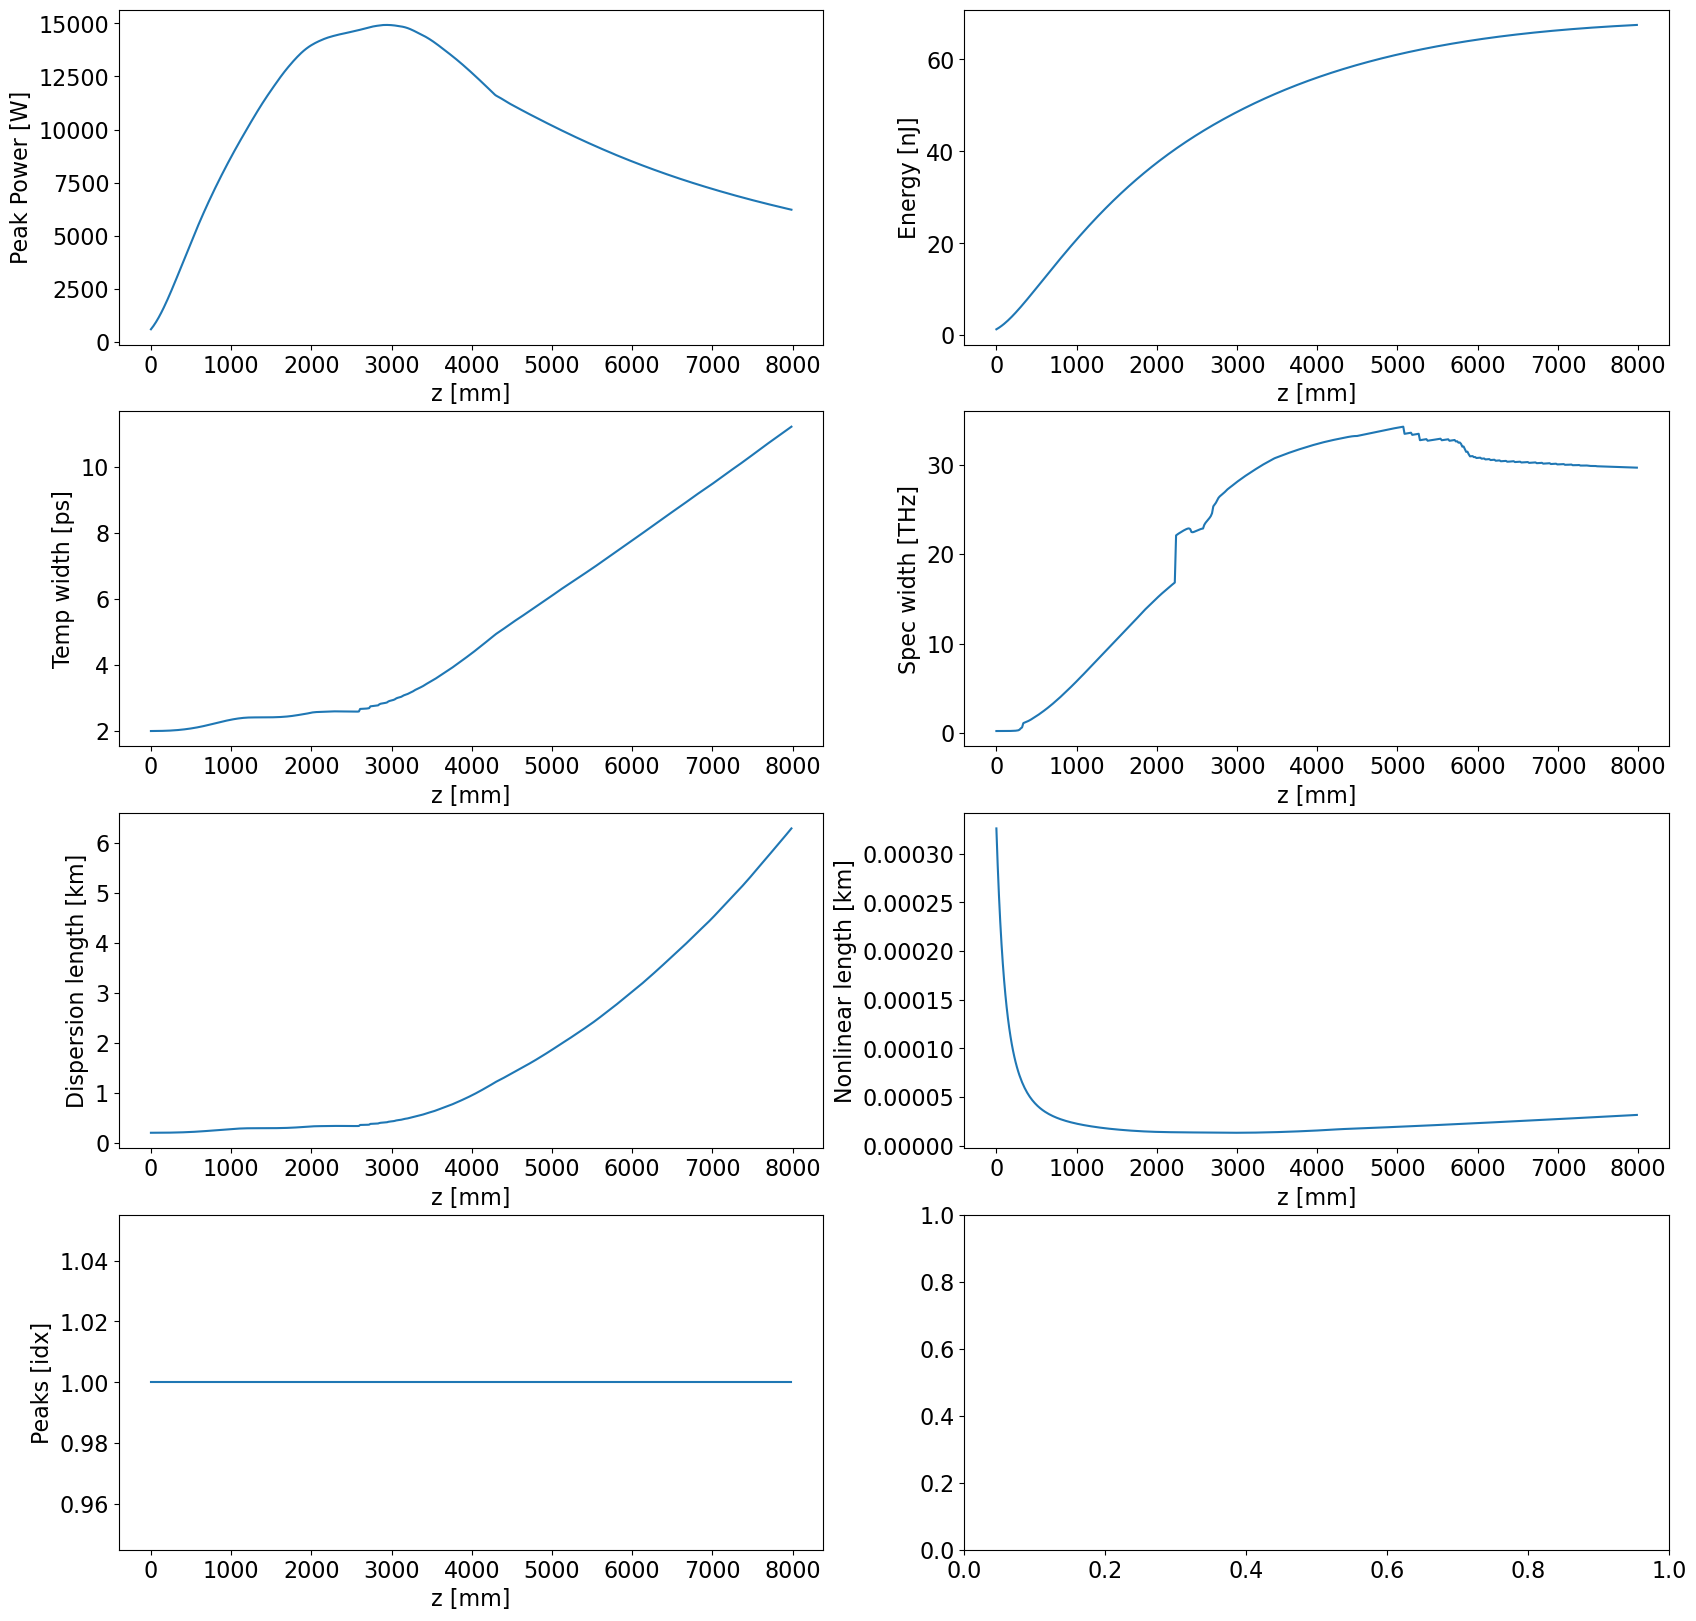

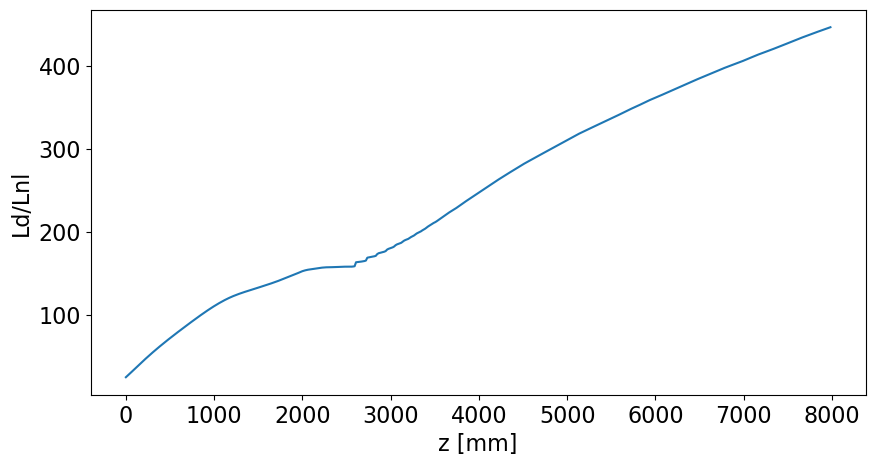

In [22]:
df_results = sys0.df_results
visualise_results_df(df_results)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

N_arr = np.sqrt(df_results['Dispersion length [km]'].values/df_results['Nonlinear length [km]'].values)
z_arr = df_results.index.get_level_values("z [mm]").values
ax.plot(z_arr, N_arr)
ax.set_xlabel(f"z [mm]")
ax.set_ylabel(f"Ld/Lnl")

### Check evolution in z range

z current is  4640.266666666666 mm


(-30.0, 30.0)

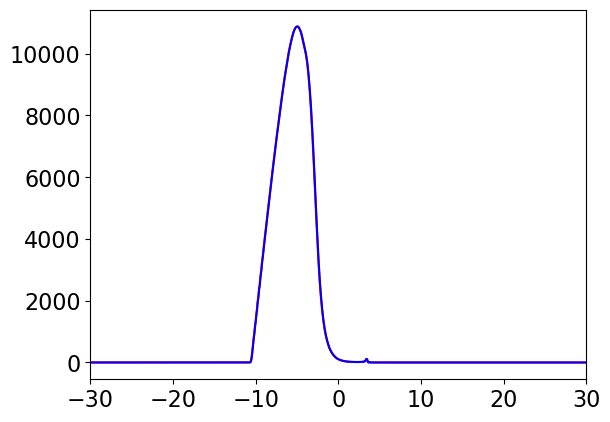

In [24]:
i = 290
print(f"z current is  {z_arr[i]} mm")
plt.plot(interpolated_t, sys0.df_temp.values[i], color="r")
plt.plot(interpolated_t, sys1.df_temp.values[i], color="b")
plt.xlim(-30, 30)